In [1]:
!pip install tensorflow
!pip install -q tf-models-official==2.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 44.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 12.3 MB/s eta 0:00:00
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77056 sha256=a56927f2f2ff97838c5fa2537cdaa80781ae15e5fb43c0c29b5531273312ea27
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.14.0
    Uninstalling wrapt-1.14.0:
      Successfully uninstalled wrapt-1.14.0
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.2.0
    Uninstalling typing_extensions-4.2.0:
      Successfully uninstalled typing_extensions-4.2.0
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Att

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [3]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

2022-05-24 11:49:15.133258: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [4]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"

In [5]:
df = pd.read_json("../input/squad-process-2/squad_process_2.json")

In [6]:
df.head()

,question,answers,mask
0,when did beyonce start becoming popular?,[in the late 1990s],[when]
1,what areas did beyonce compete in when she was...,[singing and dancing],[what]
2,when did beyonce leave destiny's child and bec...,[2003],[when]
3,in what city and state did beyonce grow up?,"[Houston, Texas]",[what]
4,in which decade did beyonce become famous?,[late 1990s],[which]


In [7]:
len(df)

130319

In [8]:
df["mask"].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[what]            75799
[who]             13396
[when]             8199
[which]            8048
[how, many]        7035
[where]            5263
[how]              5173
[]                 1980
[why]              1906
[how, much]         975
[what, other]       803
[that]              464
[whose]             455
[whom]              442
[what, new]         184
[which, other]      107
[which, new]         33
[whos]                8
[which, first]        4
[what, first]         4
[whats]               4
[whar]                3
[what, many]          3
[how, other]          2
[whate]               2
[whose, other]        2
[whatever]            2
[wha]                 2
[whi]                 2
[whhat]               2
[what, much]          1
[wwhat]               1
[whichgroup]          1
[wich]                1
[when, first]         1
[`why]                1
[where, many]         1
[whad]                1
[wher]                1
[who, new]            1
[whn]                 1
[whao]          

In [9]:
df_new = pd.DataFrame()

In [10]:
# Creating new dataframe with labels that have adequate sampling for training

keep = [["what"], ["who"], ["when"], ["which"], ["how", "many"], ["where"], ["how"], ["why"], ["how", "much"]]

for w in keep:
    counter = 0
    for i in range(len(df)):
        if df["mask"][i] == w:
            counter += 1
            if counter <= 975:
                df_new = df_new.append(df.iloc[i])

In [11]:
df_new

,question,answers,mask
1,what areas did beyonce compete in when she was...,[singing and dancing],[what]
3,in what city and state did beyonce grow up?,"[Houston, Texas]",[what]
5,in what r&b group was she the lead singer?,[Destiny's Child],[what]
6,what album made her a worldwide known artist?,[Dangerously in Love],[what]
9,what role did beyoncé have in destiny's child?,[lead singer],[what]
...,...,...,...
129677,how much money did the thirteen million hunter...,[over $20.5 billion],"[how, much]"
129704,how much of the nation's endangered species is...,[one third],"[how, much]"
129715,how much money has the sale of federal duck st...,[$670 million],"[how, much]"
129720,how much money has been generated due to the d...,[$670 million],"[how, much]"


In [12]:
df_new["mask"].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[what]         975
[who]          975
[when]         975
[which]        975
[how, many]    975
[where]        975
[how]          975
[why]          975
[how, much]    975
Name: mask, dtype: int64

In [13]:
len(df_new)

8775

In [14]:
df_new.reset_index(drop=True, inplace=True)

PREPROCESSING DATA

In [15]:
df_new.head()

,question,answers,mask
0,what areas did beyonce compete in when she was...,[singing and dancing],[what]
1,in what city and state did beyonce grow up?,"[Houston, Texas]",[what]
2,in what r&b group was she the lead singer?,[Destiny's Child],[what]
3,what album made her a worldwide known artist?,[Dangerously in Love],[what]
4,what role did beyoncé have in destiny's child?,[lead singer],[what]


In [16]:
# Formatting data so that the mask in question = "<qw>"
for i in range(len(df_new)):
    df_new["question"][i] = df_new["question"][i].split()
    for j in range(len(df_new["question"][i])):
        if df_new["question"][i][j] in df_new["mask"][i]:
            if "<qw>" not in df_new["question"][i]:
                df_new["question"][i][j] = "<qw>" 
            else:
                df_new["question"][i].pop(j)
                break

In [17]:
df_new["inputs"] = np.nan

In [18]:
for i in range(len(df_new)):
    df_new["question"][i] = " ".join(df_new["question"][i])
    df_new["answers"][i] = " ".join(df_new["answers"][i])
    df_new["inputs"][i] = [df_new["question"][i], df_new["answers"][i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from 

In [19]:
labels_unique = []
idx = []
num = 0
for i in range(len(df_new["mask"])):
    if df_new["mask"][i] not in labels_unique:
        labels_unique.append(df_new["mask"][i])
        idx.append(num)
        num += 1

labels_idx = np.stack((idx, labels_unique)).T

/opt/conda/lib/python3.7/site-packages/numpy/core/shape_base.py:420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [20]:
labels_idx

array([[0, list(['what'])],
       [1, list(['who'])],
       [2, list(['when'])],
       [3, list(['which'])],
       [4, list(['how', 'many'])],
       [5, list(['where'])],
       [6, list(['how'])],
       [7, list(['why'])],
       [8, list(['how', 'much'])]], dtype=object)

In [21]:
# Turning masks into numerical cateogries
for i in range(len(df_new)):
    for j in range(len(labels_idx)):
        if df_new["mask"][i] == labels_idx[j][1]:
            df_new["mask"][i] = labels_idx[j][0]

In [22]:
df_new.head()

,question,answers,mask,inputs
0,<qw> areas did beyonce compete in when she was...,singing and dancing,0,[<qw> areas did beyonce compete in when she wa...
1,in <qw> city and state did beyonce grow up?,"Houston, Texas",0,"[in <qw> city and state did beyonce grow up?, ..."
2,in <qw> r&b group was she the lead singer?,Destiny's Child,0,"[in <qw> r&b group was she the lead singer?, D..."
3,<qw> album made her a worldwide known artist?,Dangerously in Love,0,[<qw> album made her a worldwide known artist?...
4,<qw> role did beyoncé have in destiny's child?,lead singer,0,[<qw> role did beyoncé have in destiny's child...


In [23]:
X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(df_new["inputs"], df_new["mask"], test_size=0.1, random_state=42)

In [24]:
print(X_train_og.shape)
print(X_test_og.shape)
print(y_train_og.shape)
print(y_test_og.shape)

(7897,)
(878,)
(7897,)
(878,)


In [25]:
X_train = {"questions": [], "answers": [], "labels": []}

for row in X_train_og:
    X_train["questions"].append(row[0])
    X_train["answers"].append(row[1])

for row in y_train_og:
    X_train["labels"].append(row)

In [26]:
X_test = {"questions": [], "answers": [], "labels": []}

for row in X_test_og:
    X_test["questions"].append(row[0])
    X_test["answers"].append(row[1])

for row in y_test_og:
    X_test["labels"].append(row)

In [27]:
df_train = pd.DataFrame(X_train)
df_train

,questions,answers,labels
0,<qw> precipitation does heron recieve?,34.70 inches,8
1,<qw> is different about chopin's waltzes versu...,faster tempos,0
2,"in kilometers, <qw> far is derriford hospital ...",6,6
3,<qw> are staples of classical music often used?,commercially,6
4,<qw> a comic panel has events that are not at ...,asynchronous,2
...,...,...,...
7892,"the idea of ""carpatho-ruthenian"" nation is sup...",Transcarpathia and abroad,5
7893,<qw> was a protest organized about the olympic...,Delhi,5
7894,<qw> does the fund work to raise awareness and...,developing countries,5
7895,<qw> format is used for ipod game files?,.ipg,0


In [28]:
df_test = pd.DataFrame(X_test)
df_test

,questions,answers,labels
0,<qw> profit did the cloud storage business net...,$1.2bn,8
1,<qw> large was the displacement?,up to 9 meters,6
2,"<qw> judge quit before the premiere, citing im...",DJ Stryker,3
3,<qw> do prokaryotes store their genomes?,"on a single large, circular chromosome",6
4,<qw> was credited for her cries on the song?,B.I.C.,1
...,...,...,...
873,<qw> had their final season in the show in sea...,Simon Cowell,1
874,<qw> did apple originally tell consumers to pu...,refurbished replacement iPod,0
875,<qw> planes of existence?,31,4
876,<qw> does alice jones describe her?,she's almost too good,6


In [29]:
for key, value in X_train.items():
  print(f"{key:9s}: {value[0]}")

questions: <qw> precipitation does heron recieve?
answers  : 34.70 inches
labels   : 8


In [30]:
for key, value in X_test.items():
  print(f"{key:9s}: {value[0]}")

questions: <qw> profit did the cloud storage business net in 2012?
answers  : $1.2bn
labels   : 8


BERT tokenizer

In [31]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [32]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


Encode the sentences

In [33]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [34]:
X_train["questions"] = tf.convert_to_tensor(X_train["questions"])
X_train["answers"] = tf.convert_to_tensor(X_train["answers"])

X_test["questions"] = tf.convert_to_tensor(X_test["questions"])
X_test["answers"] = tf.convert_to_tensor(X_test["answers"])

2022-05-24 11:49:56.035319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 11:49:56.159093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 11:49:56.159974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 11:49:56.162042: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [35]:
X_train["questions"]

<tf.Tensor: shape=(7897,), dtype=string, numpy=
array([b'<qw> precipitation does heron recieve?',
       b"<qw> is different about chopin's waltzes versus a ballroom waltz?",
       b'in kilometers, <qw> far is derriford hospital from the plymouth city center?',
       ...,
       b'<qw> does the fund work to raise awareness and provide support?',
       b'<qw> format is used for ipod game files?',
       b'<qw> did chesapeake bay colonists begin to buy slaves?'],
      dtype=object)>

In [36]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s.numpy()))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

questions = tf.ragged.constant([
    encode_sentence(s) for s in X_train["questions"]])
answers = tf.ragged.constant([
    encode_sentence(s) for s in X_train["answers"]])

In [37]:
print("answers shape:", questions.shape.as_list())
print("answers shape:", answers.shape.as_list())

answers shape: [7897, None]
answers shape: [7897, None]


In [38]:
questions[0]

<tf.Tensor: shape=(12,), dtype=int32, numpy=
array([ 1026,  1053,  2860,  1028, 13511,  2515, 22914, 28667,  2666,
        3726,  1029,   102], dtype=int32)>

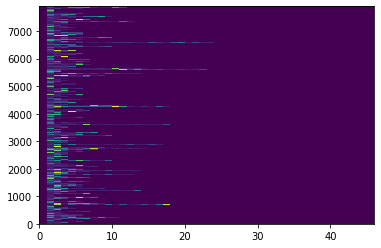

In [39]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*questions.shape[0]
input_word_ids = tf.concat([cls, answers], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

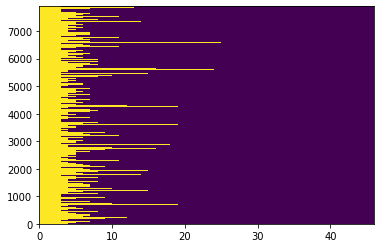

In [40]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

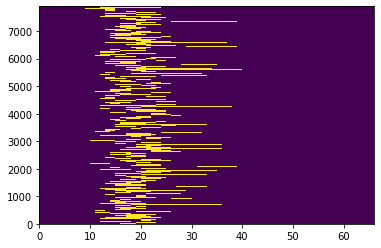

In [41]:
type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(questions)
type_s2 = tf.ones_like(answers)
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [42]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(data, tokenizer):
  num_examples = len(data["questions"])

  questions = tf.ragged.constant([
      encode_sentence(s, tokenizer) 
      for s in np.array(data["questions"])])
  answers = tf.ragged.constant([
      encode_sentence(s, tokenizer)
       for s in np.array(data["answers"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*questions.shape[0]
  input_word_ids = tf.concat([cls, questions, answers], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(questions)
  type_s2 = tf.ones_like(answers)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [43]:
X_train["answers"]

<tf.Tensor: shape=(7897,), dtype=string, numpy=
array([b'34.70 inches', b'faster tempos', b'6', ...,
       b'developing countries', b'.ipg',
       b'a continuing, critical labor shortage'], dtype=object)>

In [44]:
train_data = bert_encode(X_train, tokenizer)
train_labels = np.asarray(X_train["labels"]).astype('int64')
train_labels = tf.convert_to_tensor(train_labels)

test_data = bert_encode(X_test, tokenizer)
test_labels = np.asarray(X_test["labels"]).astype('int64')
test_labels = tf.convert_to_tensor(test_labels)

In [45]:
train_data

{'input_word_ids': <tf.Tensor: shape=(7897, 66), dtype=int32, numpy=
 array([[ 101, 1026, 1053, ...,    0,    0,    0],
        [ 101, 1026, 1053, ...,    0,    0,    0],
        [ 101, 1999, 7338, ...,    0,    0,    0],
        ...,
        [ 101, 1026, 1053, ...,    0,    0,    0],
        [ 101, 1026, 1053, ...,    0,    0,    0],
        [ 101, 1026, 1053, ...,    0,    0,    0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(7897, 66), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(7897, 66), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>}

In [46]:
print(train_data["input_word_ids"].shape)
print(train_data["input_mask"].shape)
print(train_data["input_type_ids"].shape)
print(train_labels.shape)

print(test_data["input_word_ids"].shape)
print(test_data["input_mask"].shape)
print(test_data["input_type_ids"].shape)
print(test_labels.shape)

(7897, 66)
(7897, 66)
(7897, 66)
(7897,)
(878, 53)
(878, 53)
(878, 53)
(878,)


The Model

In [47]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [48]:
print(len(labels_unique))

9


In [49]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels = len(labels_unique))

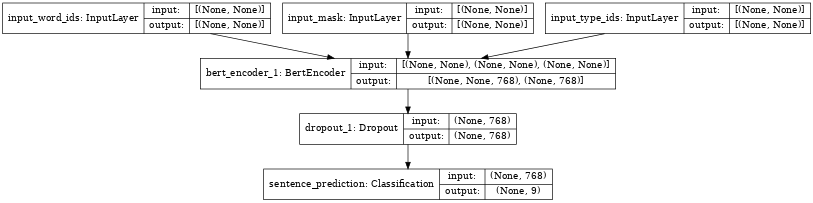

In [50]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

In [51]:
data_batch = {key: val[:10] for key, val in train_data.items()}

bert_classifier(
    data_batch, training=True
).numpy()

array([[ 0.19640815,  0.2899023 ,  0.12716031,  0.03550654,  0.0018959 ,
        -0.00975569, -0.27857393, -0.1965682 ,  0.26402292],
       [-0.07435825,  0.06197169, -0.11239322, -0.2387187 ,  0.03588458,
         0.12075544, -0.55501413, -0.20470169,  0.03065052],
       [-0.12947747,  0.20037068,  0.03764843,  0.08658382, -0.15281568,
         0.16862197, -0.47648573, -0.32328755,  0.0250666 ],
       [-0.11909141,  0.15229392,  0.12480114,  0.0141743 ,  0.19432901,
         0.0615706 , -0.3406174 , -0.39231753,  0.05172629],
       [-0.1933028 ,  0.10819504, -0.2090931 , -0.02478364, -0.11800289,
         0.0488695 , -0.28179964, -0.40460902,  0.03042769],
       [-0.12043096,  0.13604006, -0.04558951, -0.18697442,  0.06679913,
        -0.06384513, -0.21302328, -0.2417962 ,  0.02728689],
       [-0.07654022,  0.1518624 ,  0.06852265, -0.14729942,  0.21552444,
         0.04552405, -0.30325174, -0.1791135 ,  0.3432341 ],
       [-0.03040699,  0.20721698, -0.03666233,  0.07689816,  0

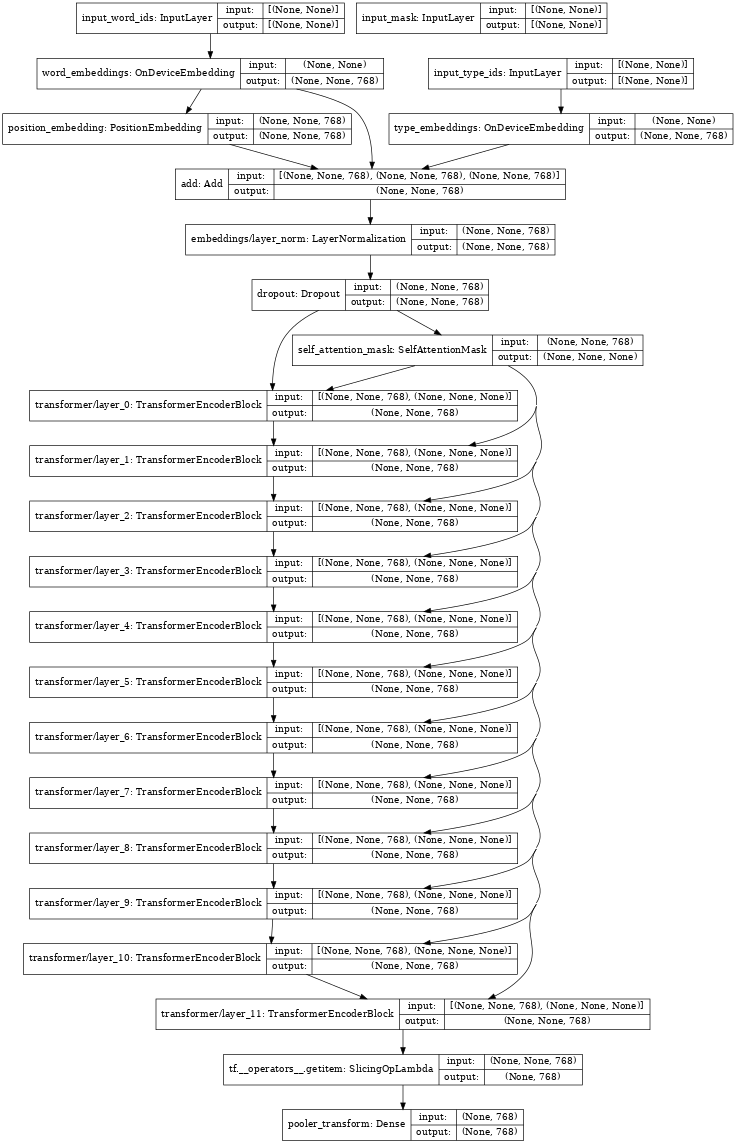

In [52]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

In [53]:
checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

Set up the optimizer

In [54]:
# Set up epochs and steps
epochs = 10
batch_size = 32
eval_batch_size = 32

train_data_size = len(train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [55]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

Train the model

In [56]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      train_data, train_labels,
      validation_data=(test_data, test_labels),
      batch_size=32, epochs=epochs)

2022-05-24 11:50:52.346425: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
247/247 [==============================] - 80s 265ms/step - loss: 1.7801 - accuracy: 0.3945 - val_loss: 0.8247 - val_accuracy: 0.7836
Epoch 2/10
247/247 [==============================] - 64s 260ms/step - loss: 0.4554 - accuracy: 0.8797 - val_loss: 0.2492 - val_accuracy: 0.9248
Epoch 3/10
247/247 [==============================] - 64s 260ms/step - loss: 0.1927 - accuracy: 0.9458 - val_loss: 0.2258 - val_accuracy: 0.9271
Epoch 4/10
247/247 [==============================] - 64s 260ms/step - loss: 0.1157 - accuracy: 0.9669 - val_loss: 0.2111 - val_accuracy: 0.9305
Epoch 5/10
247/247 [==============================] - 64s 260ms/step - loss: 0.0679 - accuracy: 0.9818 - val_loss: 0.2271 - val_accuracy: 0.9351
Epoch 6/10
247/247 [==============================] - 64s 260ms/step - loss: 0.0427 - accuracy: 0.9896 - val_loss: 0.2367 - val_accuracy: 0.9431
Epoch 7/10
247/247 [==============================] - 65s 263ms/step - loss: 0.0247 - accuracy: 0.9947 - val_loss: 0.2650 - val_ac

#### Testing handcrafted example

In [60]:
example = {
        'questions':[
            '<qw> countries are there in Europe?'],
        'answers':[
            '44.']
    }

my_examples = bert_encode(example, tokenizer)
result = bert_classifier(my_examples, training=False)
result = result.numpy()[0]

result

array([-1.4939996 , -2.0283492 , -0.7529745 , -0.8646599 ,  6.8248386 ,
       -0.7197239 , -0.92726654, -0.6289257 , -0.89821404], dtype=float32)

In [61]:
pred_label = int(np.where(result == np.amax(result))[0])
labels_idx[pred_label][1]

['how', 'many']

## Save model

In [59]:
export_dir='./saved_model'
tf.saved_model.save(bert_classifier, export_dir=export_dir)

2022-05-24 12:02:33.873081: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
